## Regression and prediction of satellite images of water bodies

**1. Prepare Problem**

In [1]:
# a) Load libraries

from numpy import asarray

import cv2
import glob

from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras import optimizers
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from pickle import dump

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# b) Load dataset

images = glob.glob("D:/PROJECTS/GitHub_Projects/Classification_Satellite_Images/Water_bodies/Images/all_classes/*.jpg")
masks = glob.glob("D:/PROJECTS/GitHub_Projects/Classification_Satellite_Images/Water_bodies/Masks/all_classes/*.jpg")

print(len(images), len(masks))

2841 2841


In total, there are 2,841 photos in each Images and Masks folders.

**2. Exploratory Data Analysis**

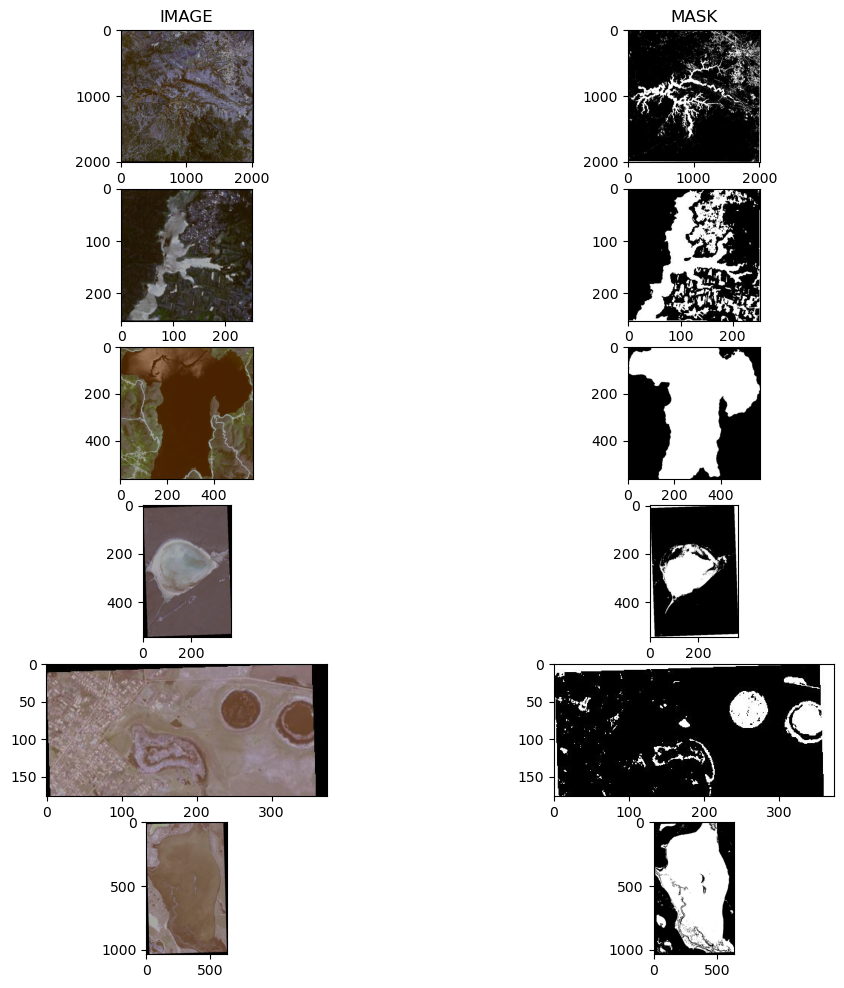

In [5]:
# a) Image visualization
# plot first few images in Images and Masks folder
f, axr = plt.subplots(6,2, figsize=(12,12))
i = 0 
for i in range(6):
    original = cv2.imread(images[i])
    mask = cv2.imread(masks[i])
    axr[i,0].imshow(original)
    axr[i,1].imshow(mask)
    i +=1
    axr[0, 0].set_title("IMAGE")
    axr[0, 1].set_title("MASK")

We can see images and masks come with different sizes and types.

In [6]:
# b) Load and resize all images in Images and Masks folders
df_images = []
for img in images:
    n = cv2.imread(img)
    n = cv2.resize(n, (128, 128))
    df_images.append(n)
df_images = asarray(df_images)

df_masks = []
for msk in masks:
    m = cv2.imread(msk, cv2.IMREAD_GRAYSCALE)
    m = cv2.resize(m, (128, 128))
    df_masks.append(m)
df_masks = asarray(df_masks)

print(len(df_images), len(df_masks))

2841 2841


**3. Prepare Data**

In [7]:
# a) Split data into train and test sets

X = df_images
y = df_masks

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2272, 128, 128, 3) (2272, 128, 128) (569, 128, 128, 3) (569, 128, 128)


In [8]:
# b) Data processing
# Flatten 128 x 128 images and convert data from numpy array to float type

X_train = X_train.reshape(X_train.shape[0], 128, 128, 3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 128, 128, 3).astype('float32')
y_train = y_train.reshape(y_train.shape[0], 128, 128).astype('float32')
y_test = y_test.reshape(y_test.shape[0], 128, 128).astype('float32')


In [9]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
y_train = y_train / 255
y_test = y_test / 255

**4. Evaluate Models**

The model we are going to use to regress and predict images is a simple neural network with one hidden layer with the same number of neurons (16384) as the visible layer.

In [16]:
# a) Define Keras Sequential model

def base_model():
    model = Sequential()
    model.add(Dense(200, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-04), loss='mean_squared_error')
    return model

# Build the model
model = base_model()

In [17]:
# Fit the model to train and test sets
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
36/36 [==============================] - 41s 1s/step - loss: 0.2929 - val_loss: 0.2766
Epoch 2/50
36/36 [==============================] - 47s 1s/step - loss: 0.2590 - val_loss: 0.2516
Epoch 3/50
36/36 [==============================] - 47s 1s/step - loss: 0.2412 - val_loss: 0.2386
Epoch 4/50
36/36 [==============================] - 50s 1s/step - loss: 0.2309 - val_loss: 0.2300
Epoch 5/50
36/36 [==============================] - 45s 1s/step - loss: 0.2227 - val_loss: 0.2220
Epoch 6/50
36/36 [==============================] - 47s 1s/step - loss: 0.2152 - val_loss: 0.2148
Epoch 7/50
36/36 [==============================] - 45s 1s/step - loss: 0.2085 - val_loss: 0.2085
Epoch 8/50
36/36 [==============================] - 49s 1s/step - loss: 0.2025 - val_loss: 0.2028
Epoch 9/50
36/36 [==============================] - 45s 1s/step - loss: 0.1972 - val_loss: 0.1979
Epoch 10/50
36/36 [==============================] - 46s 1s/step - loss: 0.1927 - val_loss: 0.1936
Epoch 11/50
36/36 [

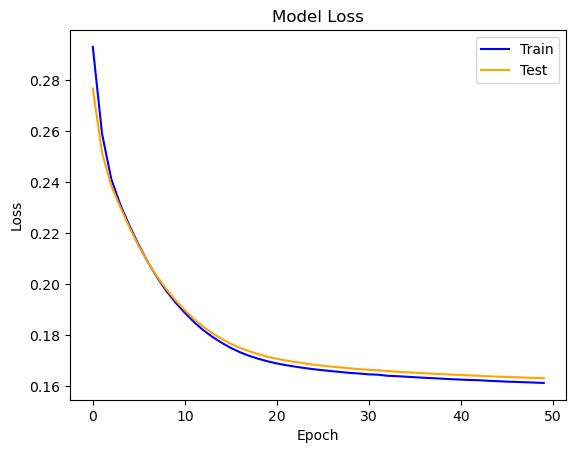

In [24]:
# Plot diagnostic learning curves
plt.title('Model Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc ="upper right")

The loss values of training and validation are in good agreement and are reasonable for such a simple CNN model.

**4. Improved Baseline Models**

In this section, we aims at improving the baseline model by applying Dropout regularization and data augmentation.

In [19]:
# Create a generator that performs simple augmentation on the baseline image, 
# specifically horizontal flips and 10% shifts in the height and width of the images in train and test sets.

gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [20]:
# Prepare iterators for each dataset
train_gen = gen.flow(X_train, y_train, batch_size=64)
test_gen = gen.flow(X_test, y_test, batch_size=64)

In [21]:
# Define Keras Sequential model with a Dropout layer
def improved_model():
    model2 = Sequential()
    model2.add(Dense(200, activation='relu'))
    model2.add(Dropout(0.2))
    model2.add(Dense(1))
    model2.compile(optimizer=optimizers.Adam(learning_rate=1e-04), loss='mean_squared_error')
    return model2

# Build the model
model2 = improved_model()

In [22]:
# Fit the model
history2 = model2.fit(train_gen, epochs=50, batch_size=64, validation_data=test_gen)

Epoch 1/50
36/36 [==============================] - 143s 4s/step - loss: 0.2740 - val_loss: 0.2590
Epoch 2/50
36/36 [==============================] - 149s 4s/step - loss: 0.2455 - val_loss: 0.2400
Epoch 3/50
36/36 [==============================] - 141s 4s/step - loss: 0.2335 - val_loss: 0.2319
Epoch 4/50
36/36 [==============================] - 140s 4s/step - loss: 0.2275 - val_loss: 0.2266
Epoch 5/50
36/36 [==============================] - 142s 4s/step - loss: 0.2228 - val_loss: 0.2218
Epoch 6/50
36/36 [==============================] - 141s 4s/step - loss: 0.2182 - val_loss: 0.2175
Epoch 7/50
36/36 [==============================] - 139s 4s/step - loss: 0.2147 - val_loss: 0.2138
Epoch 8/50
36/36 [==============================] - 139s 4s/step - loss: 0.2115 - val_loss: 0.2107
Epoch 9/50
36/36 [==============================] - 139s 4s/step - loss: 0.2089 - val_loss: 0.2086
Epoch 10/50
36/36 [==============================] - 141s 4s/step - loss: 0.2070 - val_loss: 0.2066
Epoch 11/

We can see that contrary to what we would have hoped of a further lift in model performance, the new model performs worse than the baseline one. 

Using both Dropout regularization and data augmentation techniques together hasn't improved model's performance which can be explained by: (1) the CNN architecture is shallow with only 1 hidden layer, and (2) the dataset is actually more complex than we thought, and data augmentation introduces further complexity for the images and maskes.

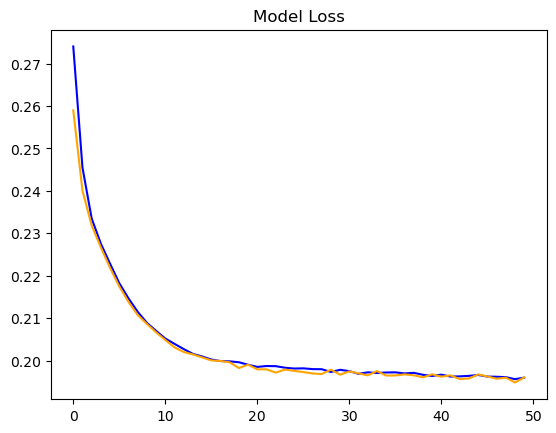

In [23]:
# Plot diagnostic learning curves
plt.title('Model Loss')
plt.plot(history2.history['loss'], color='blue', label='train')
plt.plot(history2.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc ="upper right")

Since the new model underperforms the baseline one, we will use the baseline model for prediction and finalization.

**5. Finalize Model**

1/1 [==============================] - 1s 1s/step


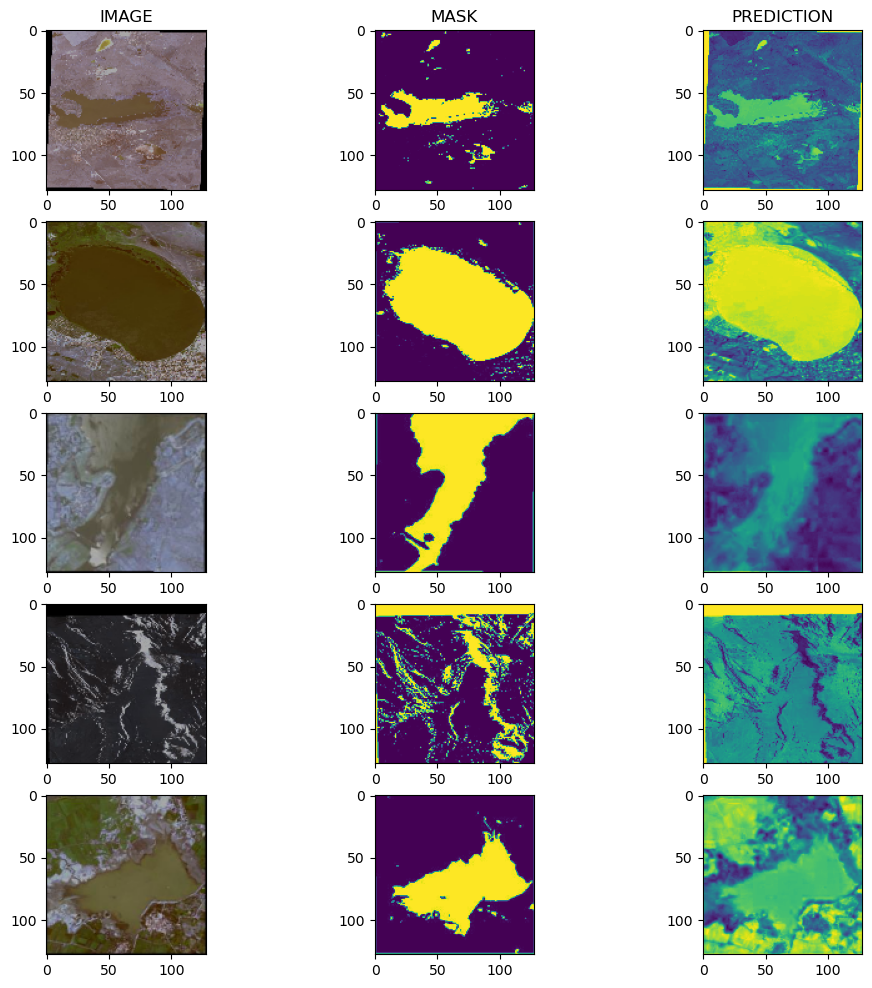

In [25]:
# a) Predictions on test data

preds = model.predict(X_test[:5])

# Plot original and predicted images
fig, ax = plt.subplots(5,3, figsize=(12,12))
i = 0 
for i in range(5):
    orig = X_test[i]
    msk = y_test[i]
    pred = preds[i]
    ax[i,0].imshow(orig)
    ax[i,1].imshow(msk)
    ax[i,2].imshow(pred)
    i +=1
    ax[0, 0].set_title("IMAGE")
    ax[0, 1].set_title("MASK")
    ax[0, 2].set_title("PREDICTION")

Overall, the predicted images capture mostly large and clear-shaped water bodies. However, further improvement by using a larger and pre-trained model might allow the model to predict features with relatively small and irregular shapes.

In [26]:
# b) Save the model for later use

# save the model to disk
filename = 'finalized_model.sav'
dump(model2, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://f49169bb-da7a-47f3-a9f8-49bc5f6e7e12/assets


**6. Conclusions**

- The image needs to be preprocessed (resize, normalize) properly before passing into the CNN model for regression and prediction.

- Satellite image introduce additional challenges, such as different sizes, resolutions, and details of objects to be detected, compared to common images.

- A simple CNN model with one hidden layer can detect and reproduce the shape of most water bodies in the image and mask dataset.

- The use of Dropout regularization and data augmentation doesn't improve the performance of the model owing to the shallowness of the CNN architecture and the complexity of the dataset.

- The model performance can be improved by using large and pre-trained models (such as ResNet-50) and will be covered in the second Notebook of this repository.